# Logistic Regression

* Flux can be used create a simple logistic regression model.
* This can be seen as one node in a neural network - an affine transformation + an activation function (softmax).
* Here we'll start using more of the typical Deep Learning tools: `Dense`, `Chain`, `softmax`, `train`, `crossentropy` and an `SGD` optimizer.
* We'll also do some basic data prep on the iris data, in particular:
    * Normalize it to have mean of 0 and standard deviation of 1.
    * Split it into training and test sets.


In [1]:
using CSV, DataFrames, Plots
using MLBase: labelmap, labelencode
using MLDataUtils: shuffleobs, splitobs
using Statistics: mean, std

using Flux, Flux.Tracker
using Flux: onehotbatch, onecold, crossentropy, data, train!

loaded


In [2]:
cd(@__DIR__)

# Download the iris data set if it is not already pressent.
isfile("iris.data") ||
    download("https://archive.ics.uci.edu/ml/machine-learning-databases/iris/iris.data", 
    "iris.data")

true

In [3]:
# Read the dataset into a dataframe.  
# None of the values are misssing, so force the datatypes of each rows to be 
# just Float64 or String with disallowmissing!.  Otherwise datatypes would be
# Union{Float64,Missing}

header = [
    :sepal_length,
    :sepal_width,
    :petal_length,
    :petal_width,
    :species
]

iris = CSV.read("iris.data", header=header, limit=150)

disallowmissing!(iris)

iris[1:5, :]

,sepal_length,sepal_width,petal_length,petal_width,species
,Float64,Float64,Float64,Float64,String
1,5.1,3.5,1.4,0.2,Iris-setosa
2,4.9,3.0,1.4,0.2,Iris-setosa
3,4.7,3.2,1.3,0.2,Iris-setosa
4,4.6,3.1,1.5,0.2,Iris-setosa
5,5.0,3.6,1.4,0.2,Iris-setosa


In [4]:
# Encode the species as an integer, call the new column 'labels'.

# https://mlbasejl.readthedocs.io/en/latest/datapre.html#data-repetition
lm = labelmap(iris[:species])

iris[:labels] = labelencode(lm, iris[:species])

iris[1:5, :]

,sepal_length,sepal_width,petal_length,petal_width,species,labels
,Float64,Float64,Float64,Float64,String,Int64
1,5.1,3.5,1.4,0.2,Iris-setosa,1
2,4.9,3.0,1.4,0.2,Iris-setosa,1
3,4.7,3.2,1.3,0.2,Iris-setosa,1
4,4.6,3.1,1.5,0.2,Iris-setosa,1
5,5.0,3.6,1.4,0.2,Iris-setosa,1


In [5]:
# Extract the first 4 cols into a matrix of floats.
# Matrix is just an alias for a 2d array, i.e. Array{Float32,2}
X_raw = Matrix{Float32}(iris[1:end, 1:4])'

# Extract the labels column as an array of 1-byte integers.
y_raw = Array{Int8}(iris[:labels]);


In [6]:
# The means and standard deviations of the raw feature matrix.
# Want them to be 0 and 1, respectively.
hcat(mean(X_raw, dims=2), std(X_raw,  dims=2))

4×2 Array{Float32,2}:
 5.84333  0.828066
 3.054    0.433594
 3.75867  1.76442 
 1.19867  0.763161

In [7]:
# Normlize.
X_raw_normed = (X_raw .- mean(X_raw, dims = 2)) ./ std(X_raw, dims = 2)

# Now can see that means are about 0 and stds are 1.
hcat(mean(X_raw_normed, dims=2), std(X_raw_normed,  dims=2))

4×2 Array{Float32,2}:
 -1.74463e-6  1.0
  2.57939e-7  1.0
  3.69549e-8  1.0
 -5.0505e-7   1.0

In [8]:
# Mix up the order of the examples, or 'observations'.
Xs, ys = shuffleobs((X_raw_normed, y_raw))

# 3 different species.  Remember that Julia has 1-based indexing
ys[1:5]

5-element Array{Int8,1}:
 2
 3
 1
 2
 1

In [9]:
# Split the data into training and test partions.
# Use 2/3 for training.
(X_train, y_train), (X_test, y_test) = splitobs((Xs, ys); at=0.67)

@show size(X_train)
@show size(X_test);

size(X_train) = (4, 100)
size(X_test) = (4, 50)


In [10]:
# One-hot encode the labels.  Probably should have done this before splitting
# the observations, but should still work.
y_train_onehot = onehotbatch(y_train, levels(y_train))
y_test_onehot  = onehotbatch(y_test,  levels(y_test))


3×50 Flux.OneHotMatrix{Array{Flux.OneHotVector,1}}:
 false  false   true   true  false  …   true  false   true  false   true
  true   true  false  false  false     false  false  false   true  false
 false  false  false  false   true     false   true  false  false  false

In [11]:
?Chain

search: Chain



```
Chain(layers...)
```

Chain multiple layers / functions together, so that they are called in sequence on a given input.

```julia
m = Chain(x -> x^2, x -> x+1)
m(5) == 26

m = Chain(Dense(10, 5), Dense(5, 2))
x = rand(10)
m(x) == m[2](m[1](x))
```

`Chain` also supports indexing and slicing, e.g. `m[2]` or `m[1:end-1]`. `m[1:3](x)` will calculate the output of the first three layers.


In [12]:
?Dense

search: Dense DenseArray DenseVector DenseMatrix DenseVecOrMat density density!



```
Dense(in::Integer, out::Integer, σ = identity)
```

Creates a traditional `Dense` layer with parameters `W` and `b`.

```
y = σ.(W * x .+ b)
```

The input `x` must be a vector of length `in`, or a batch of vectors represented as an `in × N` matrix. The out `y` will be a vector or batch of length `out`.

```julia
julia> d = Dense(5, 2)
Dense(5, 2)

julia> d(rand(5))
Tracked 2-element Array{Float64,1}:
  0.00257447
  -0.00449443
```


In [13]:
?softmax

search: softmax logsoftmax



```
softmax(xs) = exp.(xs) ./ sum(exp.(xs))
```

[Softmax](https://en.wikipedia.org/wiki/Softmax_function) takes log-probabilities (any real vector) and returns a probability distribution that sums to 1.

If given a matrix it will treat it as a batch of vectors, with each column independent.

```
julia> softmax([1,2,3.])
3-element Array{Float64,1}:
  0.0900306
  0.244728
  0.665241
```


In [14]:
# Logistic Regression Model

# 4 features input (measurements of the iris flowers).
# 3 classes output
model = Chain(
  Dense(4, 3),
  softmax
)


Chain(Dense(4, 3), NNlib.softmax)

In [15]:
# Not all functions have documentation, e.g. crossentropy and onecold below.

loss(x, y) = crossentropy(model(x), y)

loss (generic function with 1 method)

* onecold converts a 2d array of probabilities into integers

```julia
julia> A = [.1 .7 1.; .9 .3 0]
2×3 Array{Float64,2}:
 0.1  0.7  1.0
 0.9  0.3  0.0

julia> onecold(A)
3-element Array{Int64,1}:
 2
 1
 1
```

In [16]:
accuracy(x, y) = mean(onecold(model(x)) .== onecold(y))

accuracy (generic function with 1 method)

In [17]:
?SGD

search: SGD AMSGrad Signed signed Unsigned unsigned sigmoid issetgid logsigmoid



```
SGD(params, η = 0.1; decay = 0)
```

Classic gradient descent optimiser with learning rate `η`. For each parameter `p` and its gradient `δp`, this runs `p -= η*δp`.

Supports inverse decaying learning rate if the `decay` argument is provided.


In [18]:
learning_rate = 0.1

# Stochastic Gradient Descent
optimizer = SGD(params(model), learning_rate)


#43 (generic function with 1 method)

In [19]:
losses = []
train_accuracies = []
test_accuracies  = []


0-element Array{Any,1}

# Training
* train the model.
* test accuracy may be greater than training accuracy.  
* Probably because the training and test set sizes are so small - only 150 examples total.

In [20]:
?train!

search: train_accuracies y_train X_train y_train_onehot trailing_ones



```
train!(loss, data, opt)
```

For each datapoint `d` in `data` computes the gradient of `loss(d...)` through backpropagation and calls the optimizer `opt`.

Takes a callback as keyword argument `cb`. For example, this will print "training" every 10 seconds:

```julia
Flux.train!(loss, data, opt,
            cb = throttle(() -> println("training"), 10))
```

The callback can return `:stop` to interrupt the training loop.

Multiple optimisers and callbacks can be passed to `opt` and `cb` as arrays.


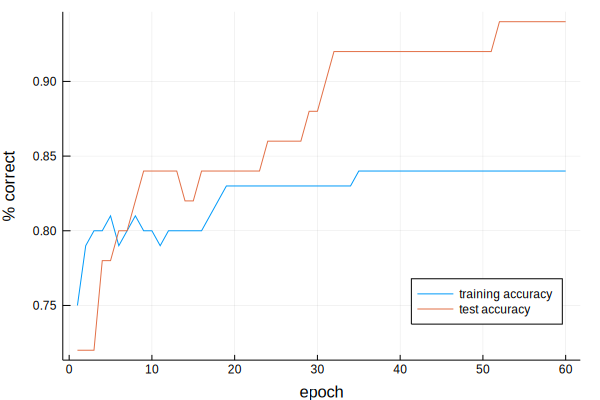

In [21]:
for epoch in 1:60
    push!(losses, data(loss(X_train, y_train_onehot)))
    push!(train_accuracies, accuracy(X_train, y_train_onehot))
    push!(test_accuracies, accuracy(X_test, y_test_onehot))

    train!(loss, [(X_train, y_train_onehot)], optimizer)
end


plot(train_accuracies, label="training accuracy", legend=:bottomright, xlabel="epoch", ylabel="% correct")
plot!(test_accuracies, label="test accuracy", legend=:bottomright)